In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"denisegorov","key":"ec36751b6b2a254da4471aad1bef3be2"}'}

In [1]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Jul 24 15:05 kaggle.json


In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download arkhoshghalb/twitter-sentiment-analysis-hatred-speech

100% 1.89M/1.89M [00:01<00:00, 2.05MB/s]
100% 1.89M/1.89M [00:01<00:00, 1.80MB/s]


In [3]:
! mkdir dataset
! unzip twitter-sentiment-analysis-hatred-speech.zip -d dataset
! rm -R twitter-sentiment-analysis-hatred-speech.zip

mkdir: cannot create directory ‘dataset’: File exists
Archive:  twitter-sentiment-analysis-hatred-speech.zip
replace dataset/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import os
import torch
from torch import nn
import pandas as pd
import numpy as np
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import re
from torch.utils.data import DataLoader, Dataset

In [5]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
import spacy

In [8]:
from matplotlib import pyplot as plt

In [9]:
import pandas as pd

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
max_words = 500
max_len = 10

In [12]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [13]:
df_train = pd.read_csv("/content/dataset/train.csv")
df_test = pd.read_csv("/content/dataset/test.csv")

In [14]:
df_train.head(3)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty


In [15]:
df_test.head(3)

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...


In [16]:
df_train, df_val = train_test_split(df_train, test_size=0.3, stratify=df_train['label'],  shuffle=True, random_state=42)

In [17]:
df_train.shape

(22373, 3)

In [18]:
df_val.shape

(9589, 3)

In [19]:
df_train.value_counts('label')

label
0    20804
1     1569
dtype: int64

In [20]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
stopwords.add('user')

In [22]:
exclude = set(punctuation)

In [23]:
nlp = spacy.load('en_core_web_sm')

In [24]:
def clean_text(text):
  txt = str(text)
  txt = "".join(c for c in txt if c not in exclude)
  txt = txt.lower()
  txt = re.sub("not\s", "not", txt)
  txt = re.sub("dont\s", "dont", txt)
  txt = re.sub("doesnt\s", "doesnt", txt)
  txt = re.sub("didnt\s", "didnt", txt)
  txt = re.sub("havent\s", "havent", txt)
  txt = re.sub("hasnt\s", "hasnt", txt)
  txt = nlp(txt)
  txt = [word.lemma_ for word in txt if word not in stopwords]
  return " ".join(txt)

In [25]:
df_train['tweet'] = df_train['tweet'].apply(clean_text)
df_val['tweet'] = df_val['tweet'].apply(clean_text)
df_test['tweet'] = df_test['tweet'].apply(clean_text)

In [26]:
df_train['tweet'][34]

'its unbelievable that in the 21st century we d need something like this again neverump   xenophobia'

In [27]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [28]:
def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [29]:
tokens = word_tokenize(train_corpus)
tokens_filtered = [word for word in tokens if word.isalnum()]
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [30]:
def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [31]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [32]:
x_train = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_train["tweet"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_test["tweet"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_val["tweet"]], dtype=np.int32)

In [33]:
x_val[0]

array([383, 324, 443, 460, 359, 365,   0,   0,   0,   0], dtype=int32)

In [34]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [35]:
def train_net(model, epochs=20, th=0.5):
  model = model.to(device)
  model.train()

  train_loss_history = []
  test_loss_history = []
  train_f1_history = []
  test_f1_history = []

  for epoch in range(epochs):
      running_loss, test_loss = 0.0, 0.0
      tp_train, tn_train, fp_train, fn_train = 0.0, 0.0, 0.0, 0.0
      tp_test, tn_test, fp_test, fn_test = 0.0, 0.0, 0.0, 0.0
      pr_train, rec_train = 0.0, 0.0
      pr_test, rec_test = 0.0, 0.0
      f1_score_train, f1_score_test = 0.0, 0.0
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data[0].to(device), data[1].to(device)

          # обнуляем градиент
          optimizer.zero_grad()
          outputs = model(inputs)

          loss = criterion(outputs, labels.float().view(-1, 1))
          loss.backward()
          optimizer.step()

          # подсчет ошибки на обучении
          running_loss += loss.item()
          # подсчет метрики на обучении
          pred_labels = torch.squeeze((outputs > th).int())
          tp_train += ((labels == pred_labels) & (labels == 1)).sum().item()
          tn_train += ((labels == pred_labels) & (labels == 0)).sum().item()
          fp_train += ((labels != pred_labels) & (labels == 0)).sum().item()
          fn_train += ((labels != pred_labels) & (labels == 1)).sum().item()

      # выводим статистику о процессе обучения
      model.eval()
      pr_train = tp_train / (tp_train + fp_train + .001)
      rec_train = tp_train / (tp_train + fn_train + .001)
      f1_score_train = 2 * pr_train * rec_train / (pr_train + rec_train + .001)
      print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Step [{i + 1}/{len(train_loader)}]. ' \
              f'Loss: {running_loss/(i+1):.3f}. ' \
              f'F1: {f1_score_train:.3f}', end='. ')

      train_loss_history.append(running_loss/(i+1))
      train_f1_history.append(f1_score_train)
      running_loss = 0.0
      tp_train, tn_train, fp_train, fn_train = 0.0, 0.0, 0.0, 0.0
      pr_train, rec_train = 0.0, 0.0
      f1_score_train = 0.0

          # выводим статистику на тестовых данных
      for j, data in enumerate(val_loader):
          test_labels = data[1].to(device)
          test_outputs = model(data[0].to(device))

          # подсчет ошибки на тесте
          test_loss += criterion(test_outputs, test_labels.float().view(-1, 1))
          # подсчет метрики на тесте
          pred_test_labels = torch.squeeze((test_outputs > th).int())
          tp_test += ((test_labels == pred_test_labels) & (test_labels == 1)).sum().item()
          tn_test += ((test_labels == pred_test_labels) & (test_labels == 0)).sum().item()
          fp_test += ((test_labels != pred_test_labels) & (test_labels == 0)).sum().item()
          fn_test += ((test_labels != pred_test_labels) & (test_labels == 1)).sum().item()

      pr_test = tp_test / (tp_test + fp_test + .001)
      rec_test = tp_test / (tp_test + fn_test + .001)
      f1_score_test = 2 * pr_test * rec_test / (pr_test + rec_test + .001)
      test_loss_history.append(test_loss.item()/(j+1))
      test_f1_history.append(f1_score_test)
      print(f'Test loss: {test_loss/(j+1):.3f}. Test F1: {f1_score_test:.3f}')
      test_loss = 0.0
      tp_test, tn_test, fp_test, fn_test = 0.0, 0.0, 0.0, 0.0
      pr_test, rec_test = 0.0, 0.0
      f1_score_test = 0.0

      model.train()

  print('Training is finished!')
  return train_loss_history, test_loss_history, train_f1_history, test_f1_history

In [36]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)

        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [37]:
model = LSTMFixedLen(vocab_size=500)

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [39]:
train_loss_history, test_loss_history, train_f1_history, test_f1_history = train_net(model)

Epoch [1/20]. Step [44/44]. Loss: 0.275. F1: 0.041. Test loss: 0.254. Test F1: 0.000
Epoch [2/20]. Step [44/44]. Loss: 0.251. F1: 0.000. Test loss: 0.222. Test F1: 0.012
Epoch [3/20]. Step [44/44]. Loss: 0.189. F1: 0.294. Test loss: 0.181. Test F1: 0.388
Epoch [4/20]. Step [44/44]. Loss: 0.153. F1: 0.488. Test loss: 0.170. Test F1: 0.444
Epoch [5/20]. Step [44/44]. Loss: 0.142. F1: 0.534. Test loss: 0.163. Test F1: 0.444
Epoch [6/20]. Step [44/44]. Loss: 0.125. F1: 0.602. Test loss: 0.166. Test F1: 0.495
Epoch [7/20]. Step [44/44]. Loss: 0.113. F1: 0.652. Test loss: 0.176. Test F1: 0.464
Epoch [8/20]. Step [44/44]. Loss: 0.104. F1: 0.674. Test loss: 0.171. Test F1: 0.520
Epoch [9/20]. Step [44/44]. Loss: 0.096. F1: 0.700. Test loss: 0.175. Test F1: 0.507
Epoch [10/20]. Step [44/44]. Loss: 0.086. F1: 0.739. Test loss: 0.193. Test F1: 0.513
Epoch [11/20]. Step [44/44]. Loss: 0.081. F1: 0.758. Test loss: 0.205. Test F1: 0.513
Epoch [12/20]. Step [44/44]. Loss: 0.073. F1: 0.784. Test loss:

In [40]:
result_dict = {'model': [], 'train_loss': [], 'test_loss': [], 'train_f1': [], 'test_f1': []}

In [41]:
def refresh_results_and_plot_history(model_name):
  result_dict['model'].append(model_name)
  result_dict['train_loss'].append(train_loss_history[-1])
  result_dict['test_loss'].append(test_loss_history[-1])
  result_dict['train_f1'].append(train_f1_history[-1])
  result_dict['test_f1'].append(test_f1_history[-1])
  plt.figure(figsize=(11,5))
  plt.plot(train_loss_history, 'b--', label='train_loss')
  plt.plot(test_loss_history, 'g--', label='test_loss')
  plt.plot(train_f1_history, 'b', label='train_f1')
  plt.plot(test_f1_history, 'g', label='test_f1')
  plt.grid()
  plt.legend()
  plt.show()

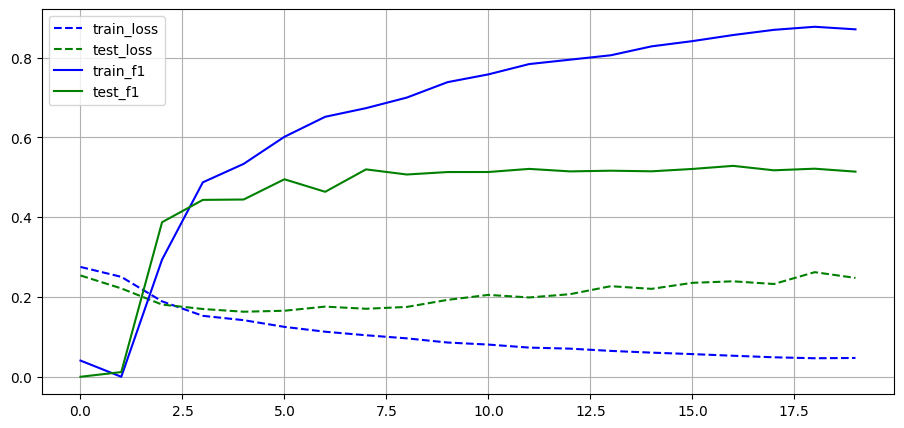

In [42]:
refresh_results_and_plot_history('LSTM')

Переобучение - лосс на тесте растет, f1 на тесте растет сильно хуже чем на трейне.

Попробуем GRU

In [43]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)

        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [44]:
model = GRUFixedLen(vocab_size=500)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [45]:
train_loss_history, test_loss_history, train_f1_history, test_f1_history = train_net(model)

Epoch [1/20]. Step [44/44]. Loss: 0.229. F1: 0.210. Test loss: 0.172. Test F1: 0.342
Epoch [2/20]. Step [44/44]. Loss: 0.157. F1: 0.472. Test loss: 0.157. Test F1: 0.431
Epoch [3/20]. Step [44/44]. Loss: 0.130. F1: 0.575. Test loss: 0.161. Test F1: 0.473
Epoch [4/20]. Step [44/44]. Loss: 0.116. F1: 0.635. Test loss: 0.162. Test F1: 0.497
Epoch [5/20]. Step [44/44]. Loss: 0.099. F1: 0.708. Test loss: 0.169. Test F1: 0.549
Epoch [6/20]. Step [44/44]. Loss: 0.084. F1: 0.748. Test loss: 0.177. Test F1: 0.532
Epoch [7/20]. Step [44/44]. Loss: 0.076. F1: 0.787. Test loss: 0.193. Test F1: 0.504
Epoch [8/20]. Step [44/44]. Loss: 0.073. F1: 0.788. Test loss: 0.209. Test F1: 0.515
Epoch [9/20]. Step [44/44]. Loss: 0.064. F1: 0.826. Test loss: 0.202. Test F1: 0.537
Epoch [10/20]. Step [44/44]. Loss: 0.060. F1: 0.831. Test loss: 0.219. Test F1: 0.529
Epoch [11/20]. Step [44/44]. Loss: 0.057. F1: 0.840. Test loss: 0.214. Test F1: 0.520
Epoch [12/20]. Step [44/44]. Loss: 0.057. F1: 0.849. Test loss:

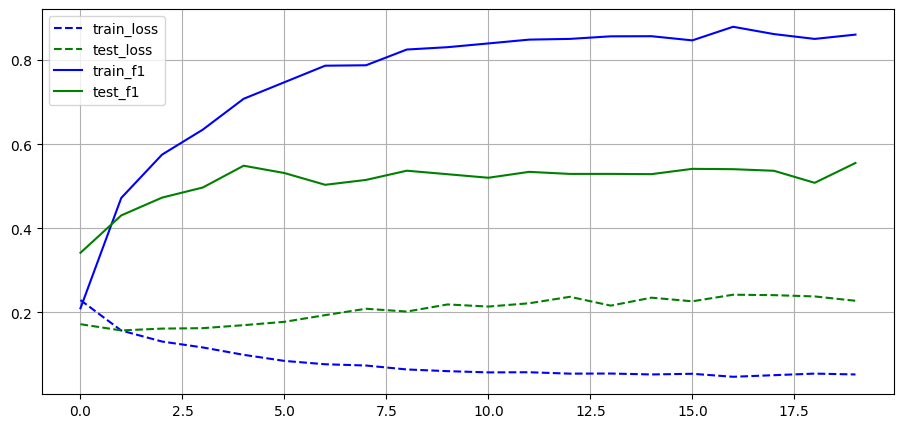

In [46]:
refresh_results_and_plot_history('GRU')

Те же успехи примерно. Попробую с дропаутом на выходе

In [47]:
class LSTMFixedLen2(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)

        out = self.linear(last_tensor)
        out = self.dropout(out)
        # print(out.shape)
        return torch.sigmoid(out)

Epoch [1/20]. Step [44/44]. Loss: 0.439. F1: 0.068. Test loss: 0.274. Test F1: 0.123
Epoch [2/20]. Step [44/44]. Loss: 0.403. F1: 0.138. Test loss: 0.239. Test F1: 0.410
Epoch [3/20]. Step [44/44]. Loss: 0.379. F1: 0.237. Test loss: 0.187. Test F1: 0.390
Epoch [4/20]. Step [44/44]. Loss: 0.371. F1: 0.327. Test loss: 0.188. Test F1: 0.389
Epoch [5/20]. Step [44/44]. Loss: 0.366. F1: 0.331. Test loss: 0.175. Test F1: 0.460
Epoch [6/20]. Step [44/44]. Loss: 0.359. F1: 0.352. Test loss: 0.174. Test F1: 0.468
Epoch [7/20]. Step [44/44]. Loss: 0.355. F1: 0.364. Test loss: 0.185. Test F1: 0.505
Epoch [8/20]. Step [44/44]. Loss: 0.353. F1: 0.398. Test loss: 0.162. Test F1: 0.463
Epoch [9/20]. Step [44/44]. Loss: 0.345. F1: 0.448. Test loss: 0.167. Test F1: 0.477
Epoch [10/20]. Step [44/44]. Loss: 0.348. F1: 0.446. Test loss: 0.172. Test F1: 0.496
Epoch [11/20]. Step [44/44]. Loss: 0.345. F1: 0.458. Test loss: 0.175. Test F1: 0.490
Epoch [12/20]. Step [44/44]. Loss: 0.345. F1: 0.467. Test loss:

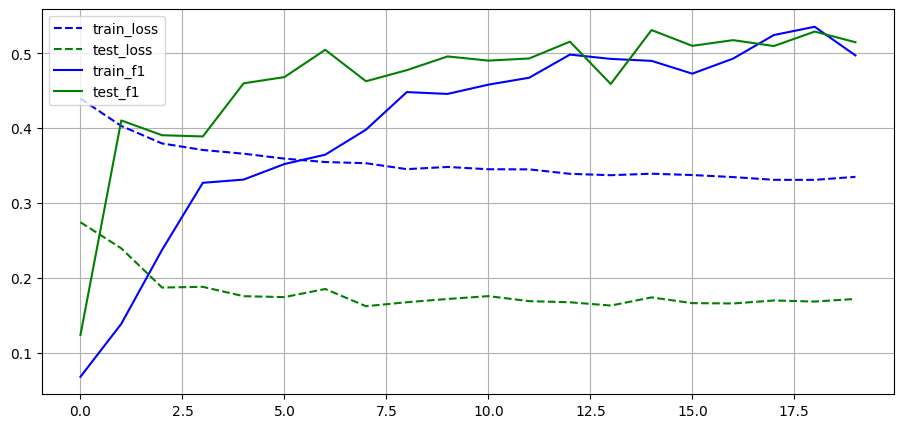

In [48]:
model = LSTMFixedLen2(vocab_size=500)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()
train_loss_history, test_loss_history, train_f1_history, test_f1_history = train_net(model)
refresh_results_and_plot_history('LSTM+DO')

Лучше, но до идеального далеко

In [49]:
class LSTMFixedLen3(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
        out = self.dropout(last_tensor)
        out = self.linear(out)

        return torch.sigmoid(out)

In [50]:
model = LSTMFixedLen3(vocab_size=500)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()
train_loss_history, test_loss_history, train_f1_history, test_f1_history = train_net(model)

Epoch [1/20]. Step [44/44]. Loss: 0.247. F1: 0.105. Test loss: 0.193. Test F1: 0.149
Epoch [2/20]. Step [44/44]. Loss: 0.177. F1: 0.343. Test loss: 0.169. Test F1: 0.459
Epoch [3/20]. Step [44/44]. Loss: 0.156. F1: 0.471. Test loss: 0.165. Test F1: 0.522
Epoch [4/20]. Step [44/44]. Loss: 0.145. F1: 0.514. Test loss: 0.165. Test F1: 0.445
Epoch [5/20]. Step [44/44]. Loss: 0.135. F1: 0.538. Test loss: 0.158. Test F1: 0.469
Epoch [6/20]. Step [44/44]. Loss: 0.126. F1: 0.574. Test loss: 0.163. Test F1: 0.459
Epoch [7/20]. Step [44/44]. Loss: 0.117. F1: 0.606. Test loss: 0.170. Test F1: 0.519
Epoch [8/20]. Step [44/44]. Loss: 0.115. F1: 0.606. Test loss: 0.166. Test F1: 0.518
Epoch [9/20]. Step [44/44]. Loss: 0.106. F1: 0.658. Test loss: 0.171. Test F1: 0.507
Epoch [10/20]. Step [44/44]. Loss: 0.103. F1: 0.658. Test loss: 0.186. Test F1: 0.542
Epoch [11/20]. Step [44/44]. Loss: 0.095. F1: 0.694. Test loss: 0.183. Test F1: 0.534
Epoch [12/20]. Step [44/44]. Loss: 0.095. F1: 0.699. Test loss:

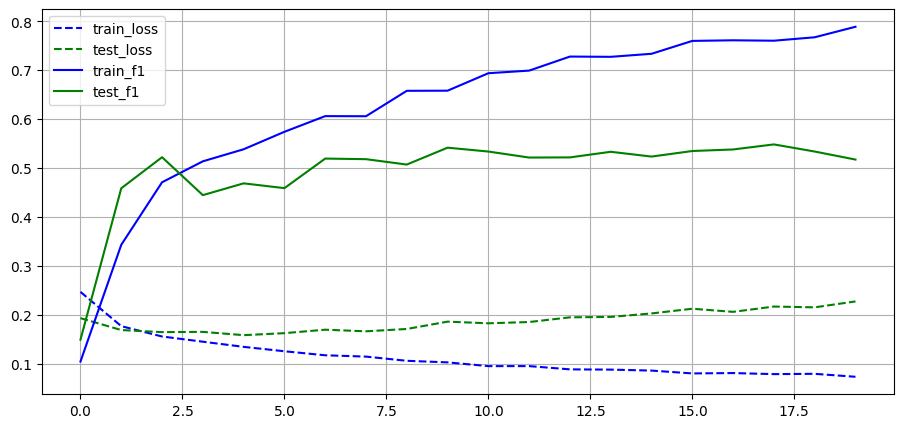

In [51]:
refresh_results_and_plot_history('LSTM+DO2')

дропаут на конце работает лучше

отключим USE_LAST

Epoch [1/20]. Step [44/44]. Loss: 0.422. F1: 0.082. Test loss: 0.216. Test F1: 0.393
Epoch [2/20]. Step [44/44]. Loss: 0.382. F1: 0.262. Test loss: 0.193. Test F1: 0.323
Epoch [3/20]. Step [44/44]. Loss: 0.369. F1: 0.300. Test loss: 0.182. Test F1: 0.386
Epoch [4/20]. Step [44/44]. Loss: 0.364. F1: 0.340. Test loss: 0.175. Test F1: 0.453
Epoch [5/20]. Step [44/44]. Loss: 0.361. F1: 0.360. Test loss: 0.187. Test F1: 0.452
Epoch [6/20]. Step [44/44]. Loss: 0.364. F1: 0.374. Test loss: 0.183. Test F1: 0.490
Epoch [7/20]. Step [44/44]. Loss: 0.353. F1: 0.408. Test loss: 0.165. Test F1: 0.480
Epoch [8/20]. Step [44/44]. Loss: 0.353. F1: 0.393. Test loss: 0.169. Test F1: 0.512
Epoch [9/20]. Step [44/44]. Loss: 0.354. F1: 0.438. Test loss: 0.175. Test F1: 0.494
Epoch [10/20]. Step [44/44]. Loss: 0.350. F1: 0.426. Test loss: 0.157. Test F1: 0.501
Epoch [11/20]. Step [44/44]. Loss: 0.345. F1: 0.461. Test loss: 0.159. Test F1: 0.508
Epoch [12/20]. Step [44/44]. Loss: 0.343. F1: 0.471. Test loss:

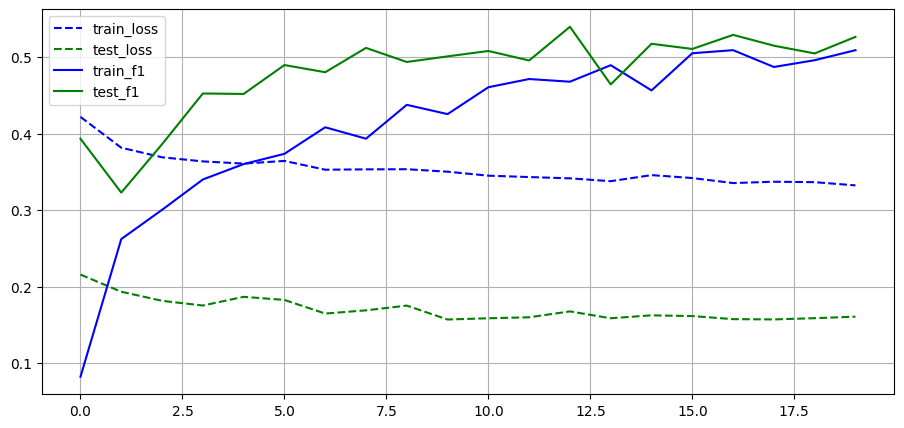

In [52]:
model = LSTMFixedLen2(vocab_size=500, use_last=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()
train_loss_history, test_loss_history, train_f1_history, test_f1_history = train_net(model)
refresh_results_and_plot_history('LSTM+DO, mean')

In [53]:
class GRUFixedLen2(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)

        out = self.linear(last_tensor)
        out = self.dropout(out)
        # print(out.shape)
        return torch.sigmoid(out)

Epoch [1/20]. Step [44/44]. Loss: 0.415. F1: 0.138. Test loss: 0.205. Test F1: 0.335
Epoch [2/20]. Step [44/44]. Loss: 0.376. F1: 0.274. Test loss: 0.197. Test F1: 0.414
Epoch [3/20]. Step [44/44]. Loss: 0.375. F1: 0.309. Test loss: 0.196. Test F1: 0.456
Epoch [4/20]. Step [44/44]. Loss: 0.365. F1: 0.353. Test loss: 0.198. Test F1: 0.439
Epoch [5/20]. Step [44/44]. Loss: 0.361. F1: 0.361. Test loss: 0.187. Test F1: 0.480
Epoch [6/20]. Step [44/44]. Loss: 0.360. F1: 0.368. Test loss: 0.175. Test F1: 0.499
Epoch [7/20]. Step [44/44]. Loss: 0.357. F1: 0.379. Test loss: 0.166. Test F1: 0.451
Epoch [8/20]. Step [44/44]. Loss: 0.355. F1: 0.414. Test loss: 0.177. Test F1: 0.499
Epoch [9/20]. Step [44/44]. Loss: 0.349. F1: 0.431. Test loss: 0.167. Test F1: 0.456
Epoch [10/20]. Step [44/44]. Loss: 0.350. F1: 0.421. Test loss: 0.172. Test F1: 0.524
Epoch [11/20]. Step [44/44]. Loss: 0.355. F1: 0.422. Test loss: 0.177. Test F1: 0.507
Epoch [12/20]. Step [44/44]. Loss: 0.346. F1: 0.431. Test loss:

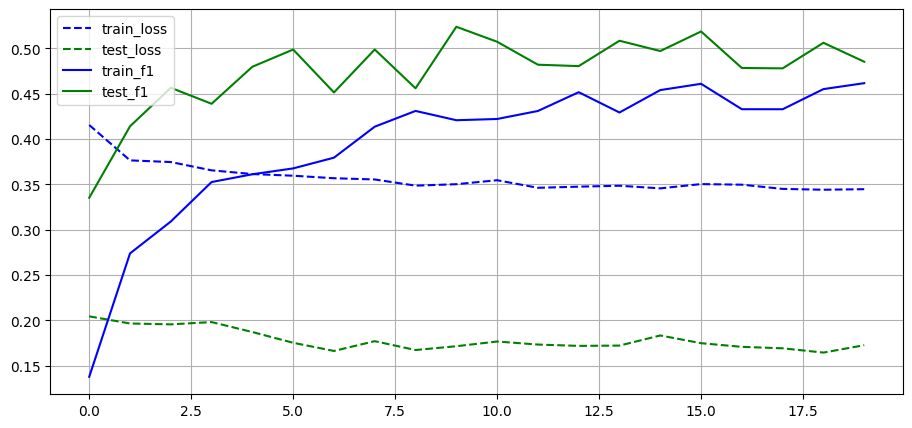

In [54]:
model = GRUFixedLen2(vocab_size=500, use_last=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()
train_loss_history, test_loss_history, train_f1_history, test_f1_history = train_net(model)
refresh_results_and_plot_history('GRU+DO, mean')

Изменим размер словарей

In [55]:
max_words = 5000
max_len = 100

In [60]:
tokens = word_tokenize(train_corpus)
tokens_filtered = [word for word in tokens if word.isalnum()]
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
x_train = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_train["tweet"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_val["tweet"]], dtype=np.int32)
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [61]:
result_df = pd.DataFrame(result_dict)

In [76]:
result_df.sort_values('test_f1', ascending=False)

,model,train_loss,test_loss,train_f1,test_f1
1,GRU,0.052169,0.227504,0.861029,0.555523
4,"LSTM+DO, mean",0.332380,0.160795,0.509138,0.526516
3,LSTM+DO2,0.073383,0.227434,0.788922,0.517451
2,LSTM+DO,0.334862,0.171626,0.497141,0.514782
0,LSTM,0.047154,0.247909,0.871194,0.514368
5,"GRU+DO, mean",0.344698,0.172755,0.461551,0.485184


 Наибольшее положительное влияние оказывает дропаут после линенйного слоя